# Seismic Geometry tutorial

One of the crucial parts of our framework is a class `SeismicGeometry` that holds information about underlying cube of amplitudes in **SEG-Y** or **HDF5** format. It can work with auxilliary headers, allowing the user to infer info and load data for the seismic volumes on various stages of processing. The main capabilities of `SeismicGeometry` are:

- infer information about traces in the cube, based on one or more headers
- collect spatial and integral statistics about amplitude values
- provide methods for loading actual data from a desired location
- convert cubes in a **SEG-Y** format to a much faster **HDF5**

To create a `SeismicGeometry` instance for a **SEG-Y** cube, we need to supply path to the cube, as well as the headers that would be used to uniquely identify each of the traces: those headers are used as index to access underlying data. Note that the only time when we load more than one trace into memory is when we specifically ask for it: all the information collection is done in a sequential way, without ever requiring too much of RAM.

This notebook demonstrates how to use the class for various types of cubes, as well as shows a number of methods and properties that help us to examine the geology:

* [Pre-stack cube with FieldRecord/TraceNumber headers](#1)
* [2D seismic with TraceNumber header](#2)
* [Post-stack cube with CDP_X/CDP_Y headers](#3)
* [Post-stack cube with INLINE_3D/CROSSLINE_3D headers](#4)
* [Post-stack cube in **HDF5** format](#5)

In [1]:
# All the necessary imports
import sys
import numpy as np

sys.path.append('..')
from seismiqb import SeismicGeometry, plot_image

<a id='#1'></a>
# Pre-stack cube: FieldRecord/TraceNumber headers

First of all, we will instantiate a regular pre-stack cube. Besides cube locaion on the disk, we need to specify:

- headers to store for each trace
- which of the headers are used as unique identifier of a trace: it must be subset of `headers` and, in our case, it is `FieldRecord` and `TraceNumber`
- whether to collect amplitude statistics and spatial stats

In [2]:
%%time
geometry = SeismicGeometry(
    '/data/seismic/CUBE_PRE/DN02B_SHOTS_LIFT1.sgy',
    headers=['FieldRecord', 'TraceNumber', 'offset'],
    index_headers=['FieldRecord', 'TraceNumber'],
    collect_stats=True, spatial=False,
)

print(geometry)



Geometry for cube              /data/seismic/CUBE_PRE/DN02B_SHOTS_LIFT1.sgy
Current index:                 ['FieldRecord', 'TraceNumber']
Shape:                         [  51 3456 3001]
Time delay and sample rate:    0, 2.0

Cube size:                     2.01 GB
Size of the instance:          0.337 GB

Number of traces:              176256

Num of unique amplitudes:      30355676
Mean/std of amplitudes:        1.58775e-06/0.290403
Min/max amplitudes:            -26.6664/26.9622
q01/q99 amplitudes:            -0.880705/0.881018

CPU times: user 14.2 s, sys: 2.36 s, total: 16.6 s
Wall time: 15.4 s


As we can see, representation of `geometry` instance gives us information about its dimensionality, as well as describes collected amplitude stats. Note the relation of the size of the instance to the size of the cube: in the case of small cubes such as this one, the `SeismicGeometry` collects amount of information, comparable to the cube volume.

For conveniency, some of the most useful combinations  of headers and index headers are already stored in the `SeismicGeometry` class as attributes:

In [3]:
print(SeismicGeometry.HEADERS_PRE_FULL)
print(SeismicGeometry.INDEX_PRE)

['FieldRecord', 'TraceNumber', 'TRACE_SEQUENCE_FILE', 'CDP', 'CDP_TRACE', 'offset']
['FieldRecord', 'TraceNumber']


A regular `pandas` dataframe describes cube structure, storing all the passed `headers`:

In [4]:
geometry.dataframe

trace_index  offset
FieldRecord TraceNumber                     
111906      1656                   0      35
            1657                   1      36
            1655                   2      78
            1658                   3      79
            1654                   4     127
...                              ...     ...
111959      3                 175957    4949
            2                 175958    4983
            143               175959    4983
            144               175960    5018
            1                 175961    5019

[175962 rows x 2 columns]

One of the main usages of `SeismicGeometry` is to load slices of amplitudes. To do so, we use `load_slide` method, that takes a number of slice that we want to load. The loading acts along the specified axis (0 by default), which corresponds to a `FieldRecord` in our case. 

In [5]:
%%time
slide = geometry.load_slide(loc=30)

CPU times: user 297 ms, sys: 91.8 ms, total: 389 ms
Wall time: 386 ms


All of the actual data loading is heavily cached: so, if we load the same slice the second time, it is performed almost instantaneously:

In [6]:
%%time
slide = geometry.load_slide(loc=30)

CPU times: user 32 µs, sys: 18 µs, total: 50 µs
Wall time: 55.3 µs


That behaviour is extremely useful when loading thousands of slices, for example, in the process of neural network training. Note that the amount of speedup, achieved by caching, may vary depending on exact sampling procedure: if we are repeatedly accessing the same slices, which would be always cached, the load would be always very fast; on the other hand, if we are to generate uniformly random slices from the entire cube, the effect would not be that noticable.

We provide `plot_image` function to visualize data: its main purpose is to parse all the arguments and use them at appropriate places of `matplotlib`:

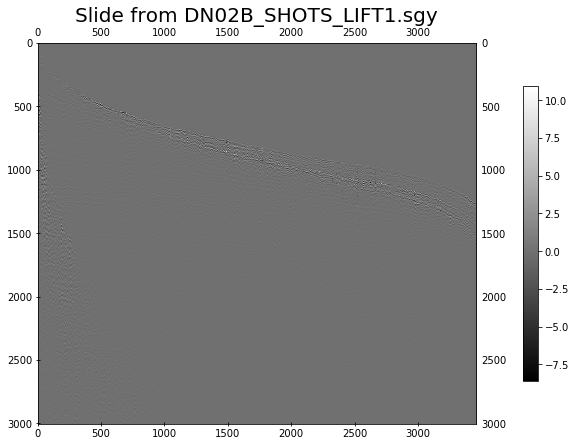

In [7]:
plot_image(slide, title=f'Slide from {geometry.name}', cmap='gray')

We also provide `show_slide` method of `SeismicGeometry` class, that adds some nice defaults like axis labels and titles:

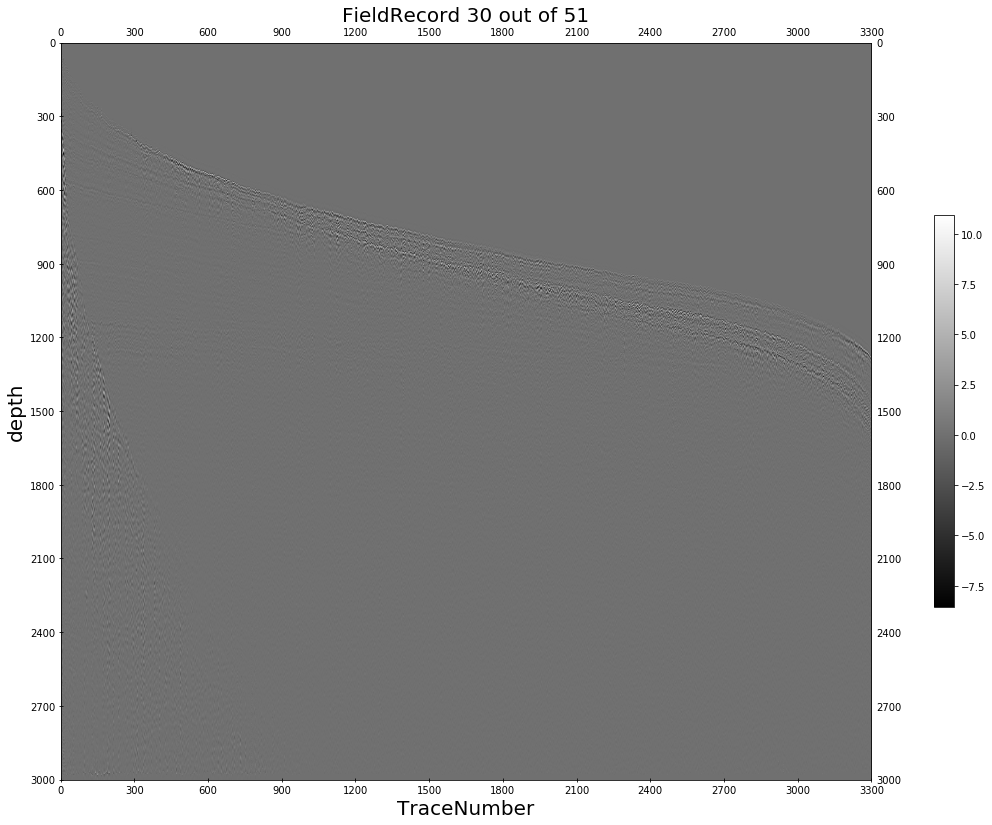

In [8]:
geometry.show_slide(loc=30, figsize=(16, 24))

As has already been noticed, the size of the instance is quite large. Most of that size is occupied by `trace_container` attribute, which stores a lot of (default value is 15000) traces from the cube, raveled into one extremely long array. That storage is really handy when it comes to exploration of the actual amplitude values: it is big enough to accurately reflect the actual amplitude distribution, so it can be used to derive all kinds of conclusions about it. A number of instance attributes are computed from this array, like `q01` (1% quantile of the amplitudes in the cube) and `q99` (the 99% quantile). 

The need for having such statistics is not exploratory: as every cube values lie in different ranges, we need to scale the amplitudes down to the same interval, for example, to $[-1; 1]$. Computing stats from each batch of data would be inefficient and innacurate: that is where precomputing all of them comes in handy.

***`keep_num` argument of the `SeismicGeometry` initialization allows to control the number of stored traces.***

Size of the trace container: 0.3349 GB
Number of stored traces: 14979
1% and 99% quantiles of the amplitudes: -0.8807050275802611, 0.8810183155536624


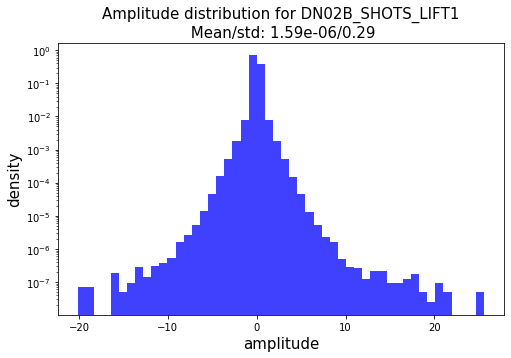

In [9]:
tc = geometry.trace_container
print(f'Size of the trace container: {tc.nbytes / (1024 ** 3):4.4} GB')
print(f'Number of stored traces: {len(tc) // geometry.depth}')
print(f'1% and 99% quantiles of the amplitudes: {geometry.q01}, {geometry.q99}')

geometry.show_amplitude_hist(log=True)

<a id='#2'></a>
# 2D seismic: TraceNumber header

During early geological exploration of a field, multiple 2D gathers are collected. Unlike regular cubes, they are actually 2 dimensional. Nevertheless, `SeismicGeometry` is capable of working with them by using only one indexing header:

In [10]:
%%time
geometry = SeismicGeometry(
    '/data/seismic/CUBE_D2/Line_2786008_LMK.segy',
    headers=SeismicGeometry.HEADERS_PRE_FULL,
    index_headers = ['TraceNumber'],
    collect_stats=True, num_keep=30, spatial=False, 
)

print(geometry)



Geometry for cube              /data/seismic/CUBE_D2/Line_2786008_LMK.segy
Current index:                 ['TraceNumber']
Shape:                         [ 611 1989]
Time delay and sample rate:    -10, 2.0

Cube size:                     0.00467 GB
Size of the instance:          0.00045 GB

Number of traces:              611

Num of unique amplitudes:      181
Mean/std of amplitudes:        0.00168166/14.9817
Min/max amplitudes:            -122.0/ 113.0
q01/q99 amplitudes:             -43.0/  41.0

CPU times: user 49.9 ms, sys: 18.9 ms, total: 68.8 ms
Wall time: 60.1 ms


Since there is only one slide of data, we don't need to specify it:

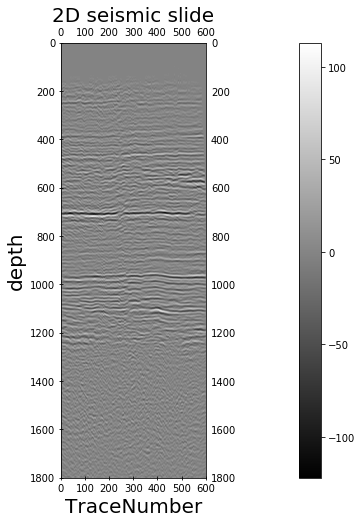

In [11]:
geometry.show_slide(figsize=(24, 8))

<a id='#3'></a>
# Post-stack: cdp_x/cdp_y headers

This is a cube after multiple steps of processing: it is already summed and each trace has a dedicated `inline` and `crossline`. Still, most of post-stack cubes still provide `cdp_x` and `cdp_y` headers for the traces. We can use them for cube loading:

In [12]:
%%time
geometry = SeismicGeometry(
    '/data/seismic/CUBE_1/E_anon.sgy',
    headers=SeismicGeometry.HEADERS_POST_FULL,
    index_headers=SeismicGeometry.INDEX_CDP,
)

print(geometry)


Geometry for cube              /data/seismic/CUBE_1/E_anon.sgy
Current index:                 ['CDP_Y', 'CDP_X']
Shape:                         [2563 1409 1501]
Time delay and sample rate:    50, 2.0

Cube size:                     21.0 GB
Size of the instance:          0.0673 GB

Number of traces:              3611267

CPU times: user 939 ms, sys: 1.09 s, total: 2.03 s
Wall time: 1.97 s


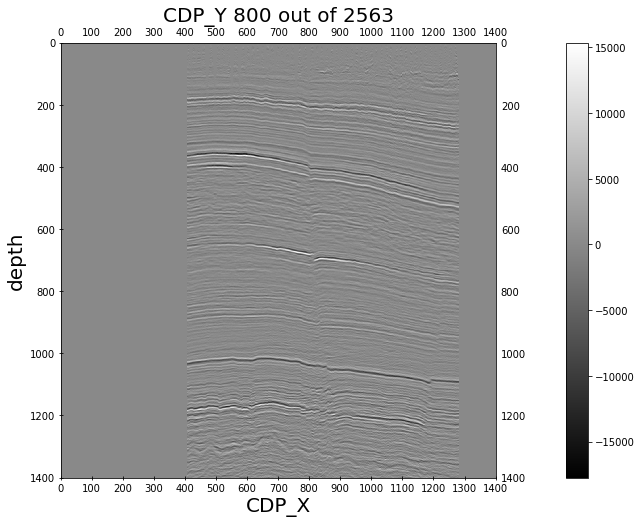

In [13]:
geometry.show_slide(loc=800, figsize=(18, 8))

Note that `inline`/`crossline` index is much preffered: those headers are represented by integer values, and their usage as index is much more robust. A common flaw of such an index is that multiple `cdp_x` can correspond to one `crossline`: a set of `10.25`, `10.2501` values can be labeled as the first crossline, which makes the unique indexing much harder to impose. 

All in all, if the `inline`/`crossline` headers are provided, always use them instead of the much more flawed `cdp_x`/`cdp_y` pair.

<a id='#4'></a>
# Post-stack: inline/crossline headers

`inline`/`crossline` index provideas a clear spatial structure, so we can also collect `spatial` stats:

In [14]:
%%time
geometry = SeismicGeometry(
    '/data/seismic/CUBE_2/M_cube.sgy',
    headers=SeismicGeometry.HEADERS_POST_FULL,
    index_headers=SeismicGeometry.INDEX_POST,
    collect_stats=True, spatial=True,
)

print(geometry)



Geometry for cube              /data/seismic/CUBE_2/M_cube.sgy
Current index:                 ['INLINE_3D', 'CROSSLINE_3D']
Shape:                         [ 418  869 2001]
Time delay and sample rate:    0, 2.0

Cube size:                     2.79 GB
Size of the instance:          0.306 GB

Number of traces:              363242
Number of non-zero traces:     352729

Num of unique amplitudes:      238
Mean/std of amplitudes:        -1.19873/4096.31
Min/max amplitudes:            -45939.2/71205.8
q01/q99 amplitudes:            -12403.6/10566.0

CPU times: user 54.2 s, sys: 3.23 s, total: 57.4 s
Wall time: 54.9 s


Collecting `spatial` stats takes some time and creates a number of additional attributes:

- `min_matrix`, `max_matrix`, `mean_matrix`, `std_matrix` store minimum, maximum, average and variance values for each of the cube traces
- `hist_matrix` stores a whole histogram of values for each trace: all of them are created with the same bins, so the distributions are directly comparable

Each `*_matrix` has the same dimensionality as the spatial range of the cube: we can see that the cube has 418 inlines and 869 crosslines, and each matrix has the same shape. Most of the cubes are padded with zero traces on the edges to have a rectangular shape; as there is no valuable stats for such traces, we fill their locations with NaNs inside every matrix, which corresponds to white filling color on images:

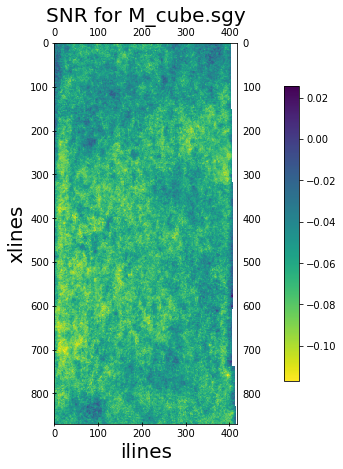

In [15]:
plot_image(geometry.mean_matrix / geometry.std_matrix,
           title=f'SNR for {geometry.name}', xlabel='ilines', ylabel='xlines')

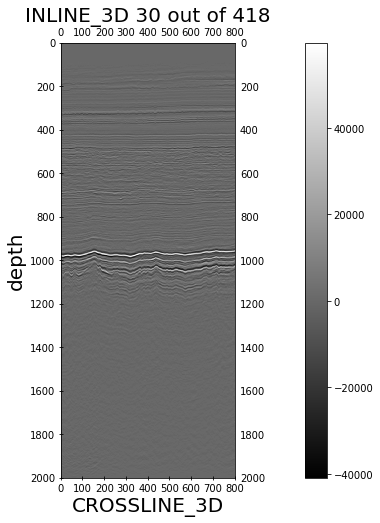

In [16]:
geometry.show_slide(loc=30, figsize=(18, 8))

As the bottom of the slide is very noisy and does not provide much insight, we would like to zoom in. `zoom_slice` parameter does exactly that:

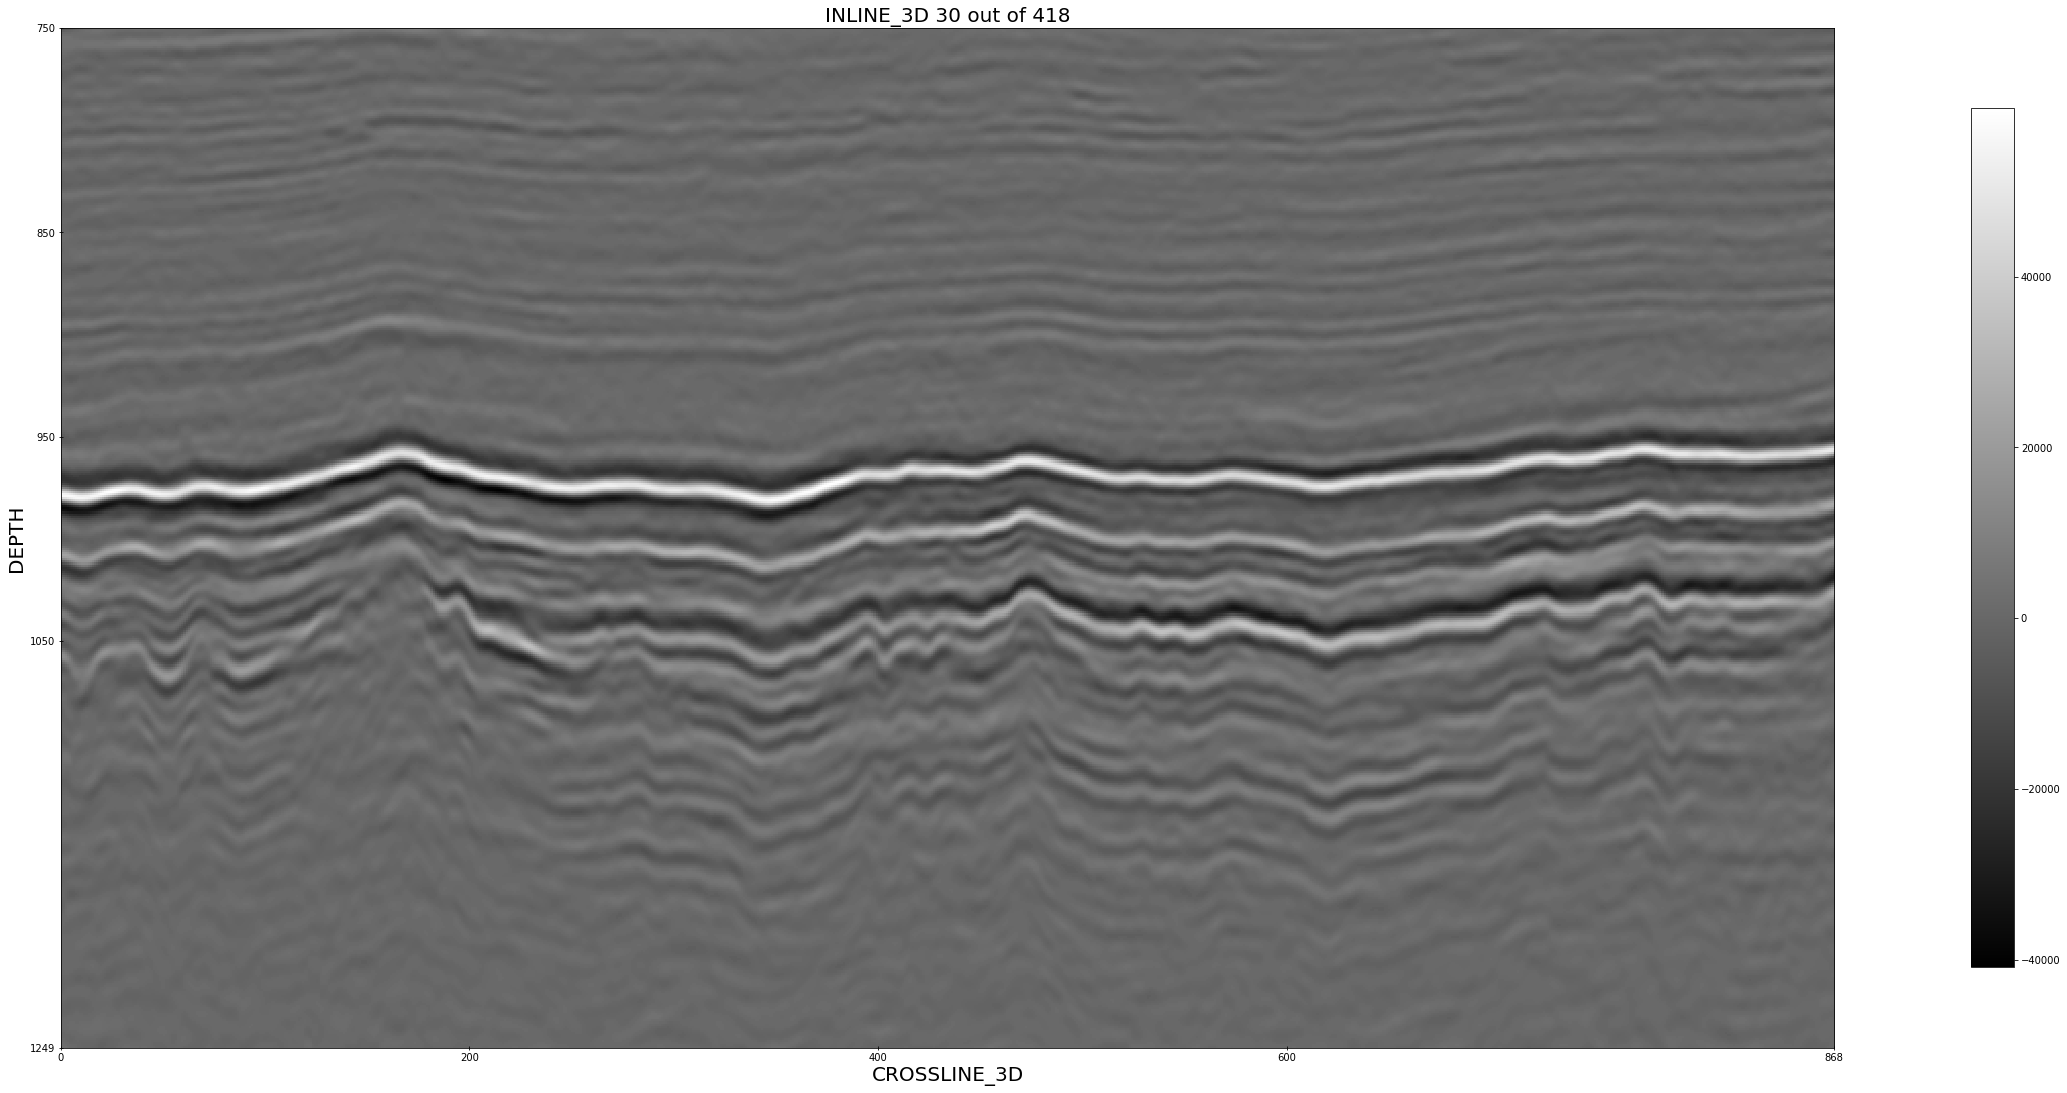

In [3]:
geometry.show_slide(loc=30, figsize=(35, 35),
                    zoom_slice=(slice(None), slice(750, 1250)))

Sometimes, change of colormap helps to distinguish reflections such as horizons and faults:

***We also zero-center the image by passing `zmin` and `zmax` values.***

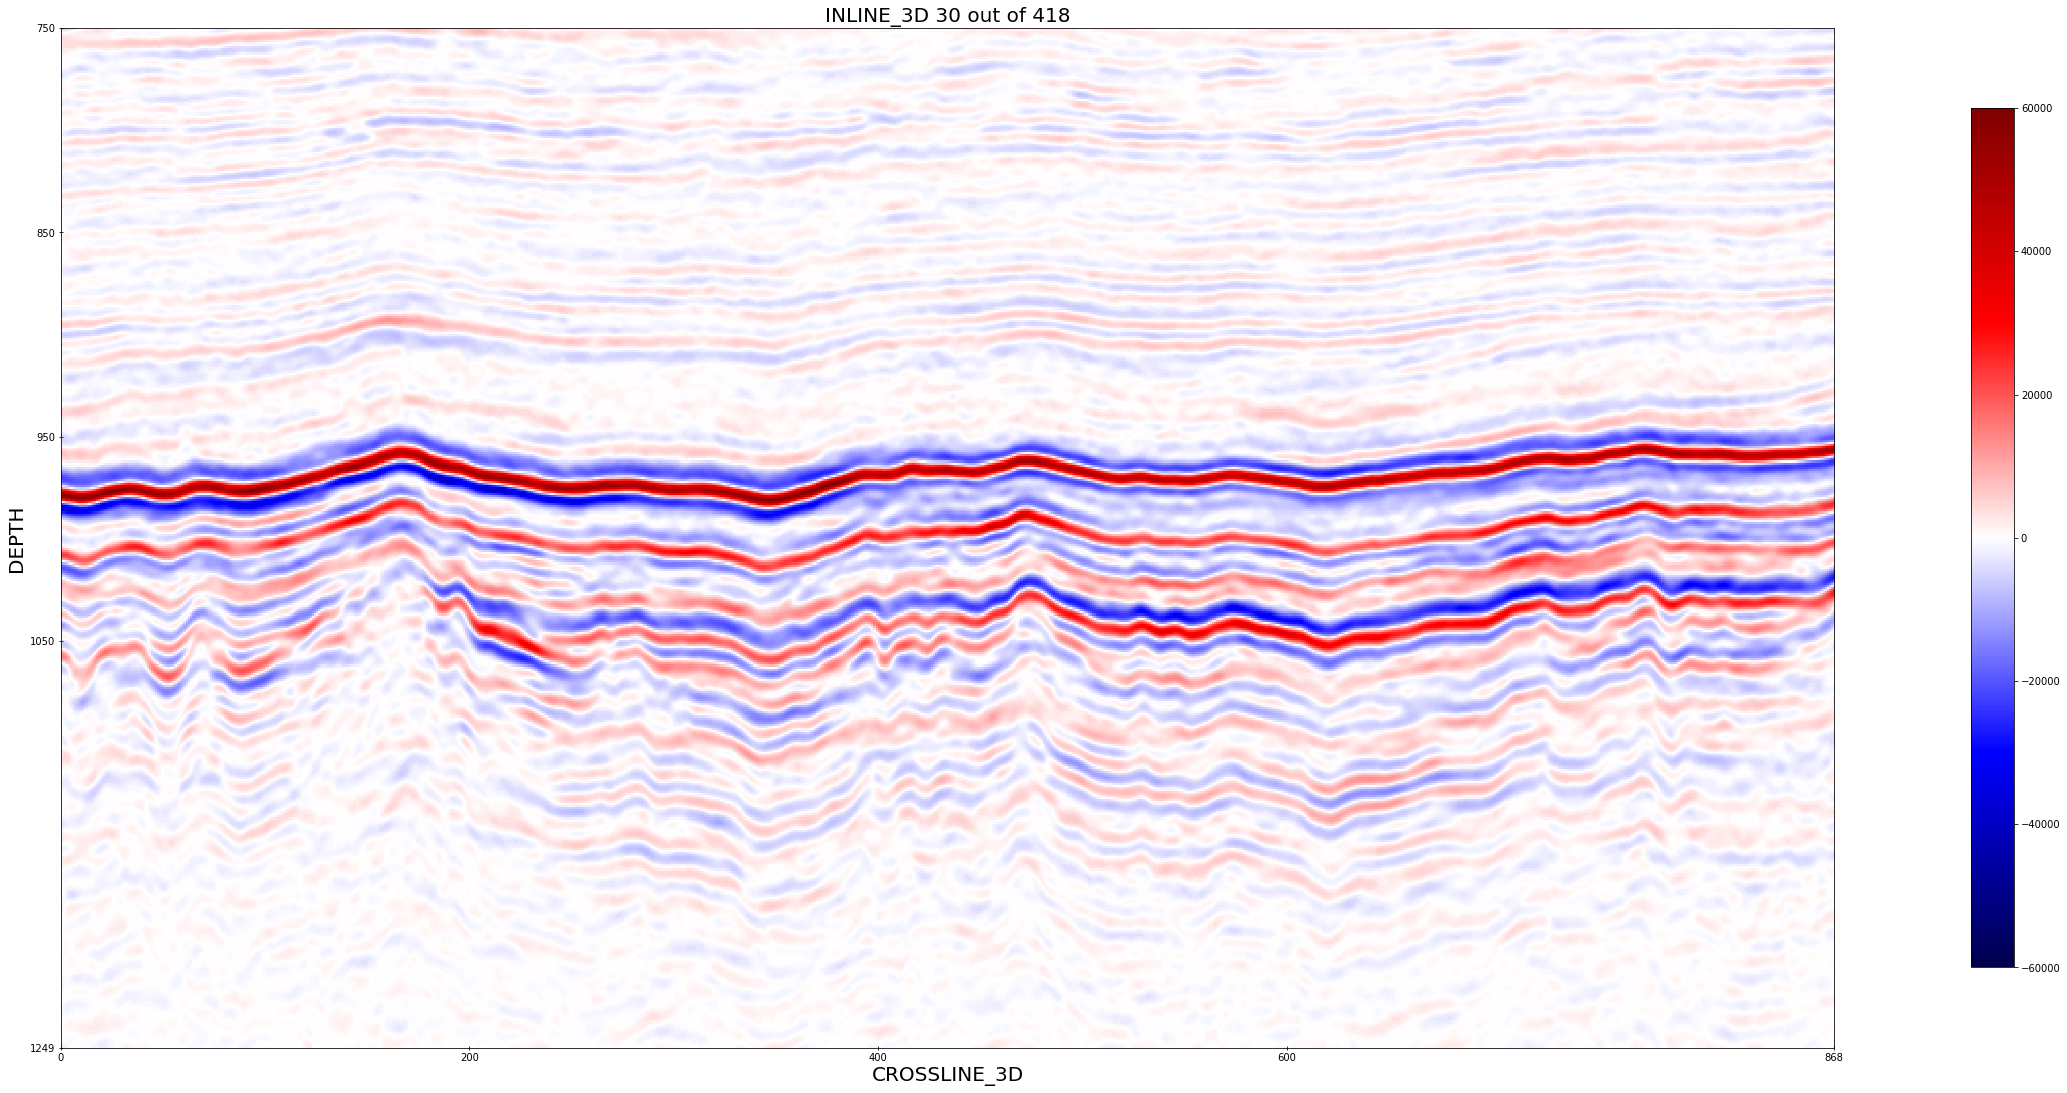

In [3]:
geometry.show_slide(loc=30, figsize=(35, 35),
                    zoom_slice=(slice(None), slice(750, 1250)),
                    cmap='seismic', zmin=-60000, zmax=60000)

you can also take a closer look at instantaneous phases using [wiggle plot](http://www.fatiando.org/v0.5/gallery/vis/seismic-wiggle.html):

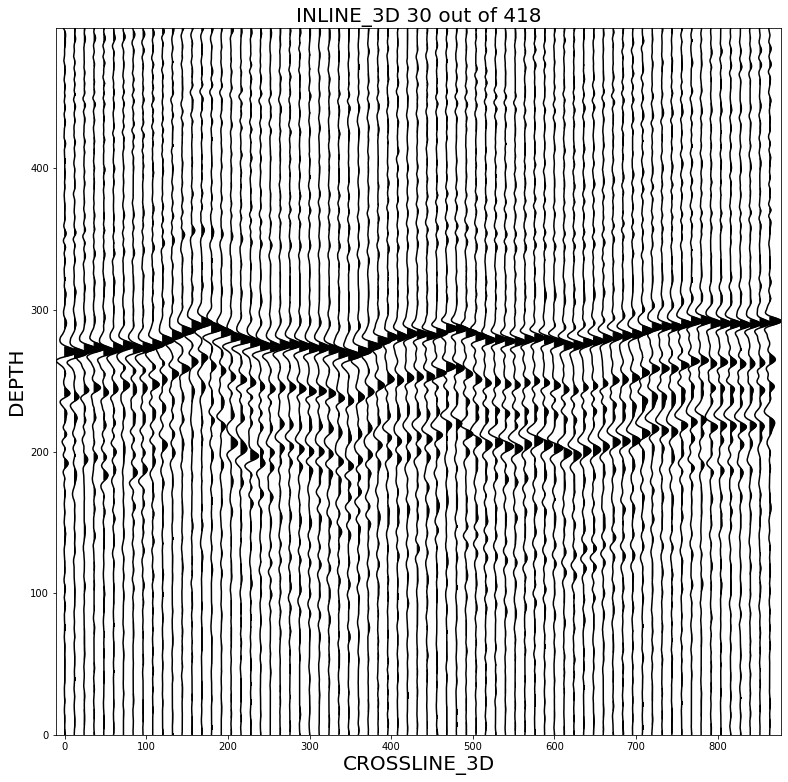

In [7]:
geometry.show_slide(loc=30, figsize=(13, 13),
                    zoom_slice=(slice(None), slice(750, 1250)), mode='wiggle', xstep=12)

As has been already mentioned, we can load and show slices along various axis:

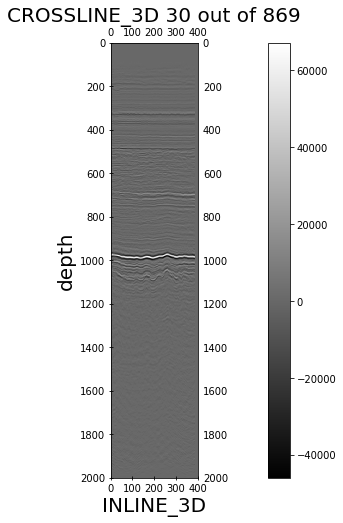

In [19]:
geometry.show_slide(loc=30, axis=1, figsize=(18, 8))

Lets check the timing of slide loading: we will compare them with a more efficient storage later.

In [20]:
%time slide = geometry.load_slide(111)
%time slide = geometry.load_slide(111)

CPU times: user 31 ms, sys: 63.5 ms, total: 94.5 ms
Wall time: 30.9 ms
CPU times: user 83 µs, sys: 17 µs, total: 100 µs
Wall time: 38.6 µs


In [21]:
# Along other axis
%time slide = geometry.load_slide(111, axis=1)
%time slide = geometry.load_slide(111, axis=1)

CPU times: user 17.4 ms, sys: 5.18 ms, total: 22.6 ms
Wall time: 18.3 ms
CPU times: user 27 µs, sys: 6 µs, total: 33 µs
Wall time: 47 µs


**SEG-Y** format is, essentially, 2D container of traces. That is not very efficient for the purposes of slide loading, and we can reshape this array into actual 3D cube of values. We store it in **HDF5** format together with all the collected stats, so the converted file does not need to infer them each time during the initialization.

***By default, HDF5 cube is stored right next to its SEG-Y counterpart.***

***Creating a 3D volume requires a strict and clear spatial structure, so converting is restricted to `iline`/`crossline` indexing headers.***

In [22]:
%%time
geometry.make_hdf5()


CPU times: user 24.3 s, sys: 25.2 s, total: 49.6 s
Wall time: 51.9 s


<a id='#5'></a>
# Post-stack: inline/crossline headers, HDF5

After converting the cube, we re-create the instance: this time, we don't need to add any other parameters, as they are already stored in the file itself.

In [23]:
geometry = SeismicGeometry('/data/seismic/CUBE_2/M_cube.hdf5')

print(geometry)


Geometry for cube              /data/seismic/CUBE_2/M_cube.hdf5
Current index:                 ['INLINE_3D', 'CROSSLINE_3D']
Shape:                         [ 418  869 2001]
Time delay and sample rate:    0, 2.0

Cube size:                     8.42 GB
Size of the instance:          0.299 GB

Number of traces:              363242
Number of non-zero traces:     352729

Num of unique amplitudes:      238
Mean/std of amplitudes:        -1.19873/4096.31
Min/max amplitudes:            -45939.2/71205.8
q01/q99 amplitudes:            -12403.6/10566.0



Note the bigger size of the cube: it is almost 3 times the size of the original **SEG-Y** cube! That is due to the fact that we store not only the `(iline, crossline, depth)` projection, but also the `(crossline, depth, iline)` and `(depth, iline, crossline)` ones: that is done to make slide loading along all the dimensions as fast as possible. As we can see, the converted version is ~10 times faster!

In [24]:
%time slide = geometry.load_slide(111)
%time slide = geometry.load_slide(111)

CPU times: user 0 ns, sys: 3.74 ms, total: 3.74 ms
Wall time: 3.68 ms
CPU times: user 233 µs, sys: 92 µs, total: 325 µs
Wall time: 337 µs


In [25]:
%time slide = geometry.load_slide(111, axis=1)
%time slide = geometry.load_slide(111, axis=1)

CPU times: user 321 µs, sys: 4.16 ms, total: 4.48 ms
Wall time: 4.48 ms
CPU times: user 374 µs, sys: 147 µs, total: 521 µs
Wall time: 541 µs


A very simple quality estimation of the seismic data can be done by looking at signal-to-noise ratio for each of the traces: in our case, it is defined as:
$$ log_{10} \frac{E(trace)^2}{Var(trace)^2}$$

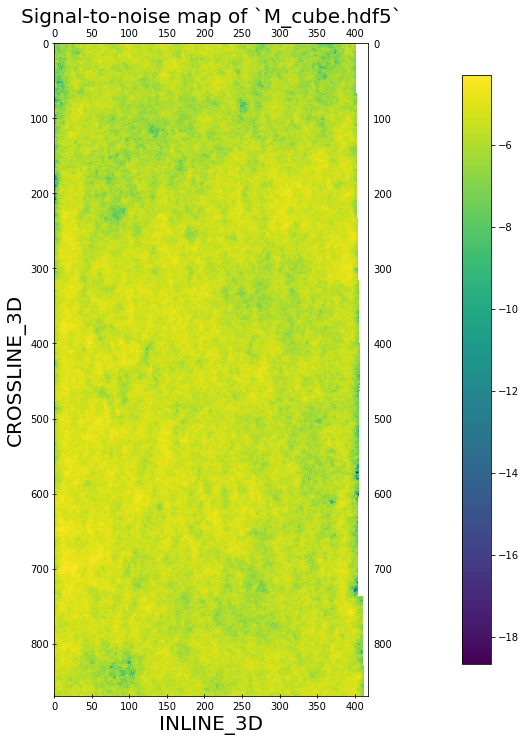

In [26]:
geometry.show_snr(figsize=(24, 12), cmap='viridis')

Obviously, all of the previous visualization functions are still available.

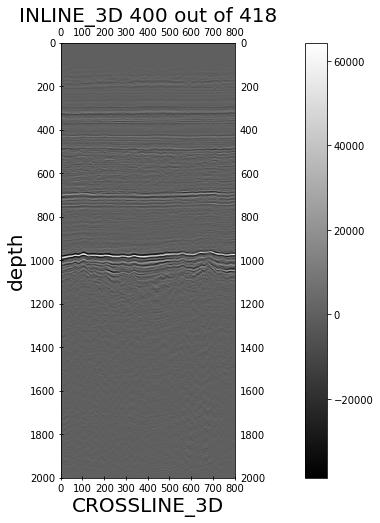

In [27]:
geometry.show_slide(loc=400, figsize=(18, 8))

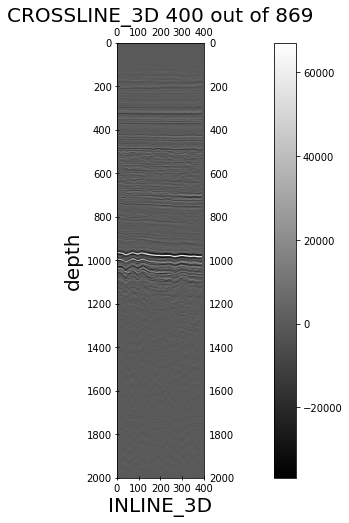

In [28]:
geometry.show_slide(loc=400, axis=1, figsize=(18, 8))

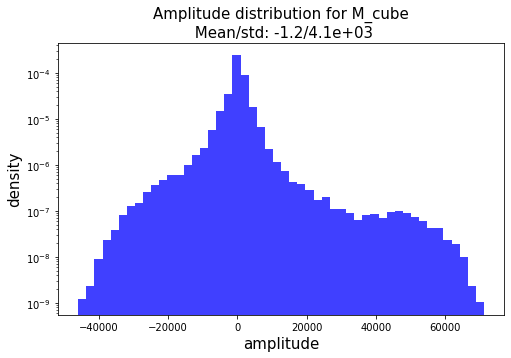

In [29]:
geometry.show_amplitude_hist(log=True)

This concludes the `SeismicGeometry` tutorial: now you know how to work with various cubes with the help of our framework. Specifically, you have learned how to:

- infer different information about 2D seismic, pre-stack and post-stack cubes
- load actual slices of data, as well as visualize them
- convert cubes with rigorous spatial structure into much faster **HDF5** format
- display simple amplitude distribution statistics

The [next tutorial](./01_Horizon.ipynb) shows how to add labeled surfaces, also known as horizons, to the cubes!